# Experiment Notebook: System Metrics

# Table of Contents
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: Sanity Checks](#Analysis-1:-Sanity-Checks)
* [Analysis 2: Correlation Matrix](#Analysis-1:-Correlation-Matrix)
* [Analysis 3: PCV at Risk](#Analysis-3:-PCV-at-Risk)
* [Analysis 4: Capital Allocation Metrics](#Analysis-4:-Capital-Allocation-Metrics)
* [Assorted Metrics](#Analysis-4:-Assorted-Metrics)

# Experiment Summary 

The purpose of this notebook is to demonstrate the system's standard metrics, KPIs and goals.

# Experiment Assumptions

See [assumptions document](../../ASSUMPTIONS.md) for further details.

# Experiment Setup

We begin with several experiment-notebook-level preparatory setup operations:

* Import relevant dependencies
* Import relevant experiment templates
* Create copies of experiments
* Configure and customize experiments 

Analysis-specific setup operations are handled in their respective notebook sections.

In [1]:
# Import the setup module:
# * sets up the Python path
# * runs shared notebook configuration methods, such as loading IPython modules
import setup

import copy
import logging
import numpy as np
import pandas as pd
import plotly.express as px

import experiments.notebooks.visualizations as visualizations
from experiments.run import run
from experiments.utils import display_code

time: 1.02 s (started: 2022-07-07 18:58:25 -04:00)


In [2]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = False

time: 21.1 ms (started: 2022-07-07 18:58:26 -04:00)


In [3]:
# Import experiment templates
import experiments.default_experiment as default_experiment

time: 22.2 ms (started: 2022-07-07 18:58:26 -04:00)


In [4]:
# Inspect experiment template
display_code(default_experiment)

"""
The default experiment with default model Initial State, System Parameters, and Simulation Configuration.
The defaults are defined in their respective modules:
* Initial State in `model/state_variables.py`
* System Parameters in `model/system_parameters.py`
* Simulation Configuration in `experiments/simulation_configuration.py`
"""

from radcad import Simulation, Experiment, Backend

from model import model
from experiments.simulation_configuration import TIMESTEPS, MONTE_CARLO_RUNS
from model.initialization import setup_initial_state, setup_state_update_blocks


# Create Model Simulation
simulation = Simulation(
    model=model,
    timesteps=TIMESTEPS,
    runs=MONTE_CARLO_RUNS
)
# Create Experiment of single Simulation
experiment = Experiment([simulation])
# Configure Simulation & Experiment engine
simulation.engine = experiment.engine
experiment.engine.backend = Backend.SINGLE_PROCESS
experiment.engine.deepcopy = True
experiment.engine.drop_substeps = True

# Configure simulation hooks
before_subset = lambda context: [
    setup_initial_state(context),
    setup_state_update_blocks(context)
]
simulation.before_subset = before_subset
experiment.before_subset = before_subset

time: 181 ms (started: 2022-07-07 18:58:26 -04:00)


In [5]:
# Create a simulation for each analysis
simulation_1 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_2 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_3 = copy.deepcopy(default_experiment.experiment.simulations[0])

time: 30 ms (started: 2022-07-07 18:58:26 -04:00)


In [6]:
# Experiment configuration
# simulation_1.model.initial_state.update({})
# simulation_1.model.params.update({})

time: 24.2 ms (started: 2022-07-07 18:58:26 -04:00)


# Analysis 1: PCV Sanity Checks

A simulation across 4 volatile asset price scenarios to validate PCV states and metrics.

In [7]:
# Analysis-specific setup
simulation_1.model.params.update({
    "volatile_asset_price_process": [
        lambda _run, _timestep: 2_000,
        lambda _run, timestep: 2_000 if timestep < 365 / 4 else (1_000 if timestep < 365 * 3/4 else 2_000),
        lambda _run, timestep: 2_000 * (1 + timestep * 0.2 / 365),
        lambda _run, timestep: 2_000 * (1 - timestep * 0.2 / 365),
    ],
})

time: 23.9 ms (started: 2022-07-07 18:58:26 -04:00)


In [8]:
# Experiment execution
df, exceptions = run(simulation_1)

2022-07-07 18:58:26,475 - root - INFO - Running experiment
2022-07-07 18:58:26,478 - root - INFO - Setting up initial state
2022-07-07 18:58:26,482 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-07 18:58:27,180 - root - INFO - Setting up initial state
2022-07-07 18:58:27,184 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-07 18:58:27,902 - root - INFO - Setting up initial state
2022-07-07 18:58:27,906 - root - INFO - Starting simulation 0 / run 0 / subset 2
2022-07-07 18:58:28,623 - root - INFO - Setting up initial state
2022-07-07 18:58:28,628 - root - INFO - Starting simulation 0 / run 0 / subset 3
2022-07-07 18:58:29,342 - root - INFO - Experiment complete in 2.865471124649048 seconds
2022-07-07 18:58:29,343 - root - INFO - Post-processing results
2022-07-07 18:58:31,045 - root - INFO - Post-processing complete in 1.70344877243042 seconds
time: 4.6 s (started: 2022-07-07 18:58:26 -04:00)


In [9]:
# Post-processing and visualizations

time: 21.5 ms (started: 2022-07-07 18:58:31 -04:00)


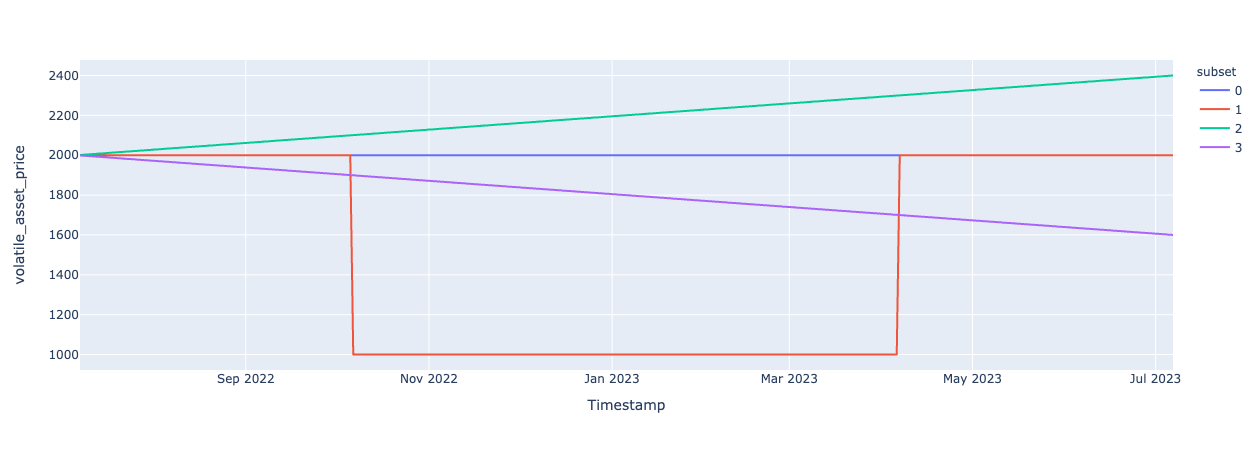

time: 931 ms (started: 2022-07-07 18:58:31 -04:00)


In [10]:
fig = df.plot(y='volatile_asset_price', color='subset')

fig.update_xaxes(title='Timestamp')

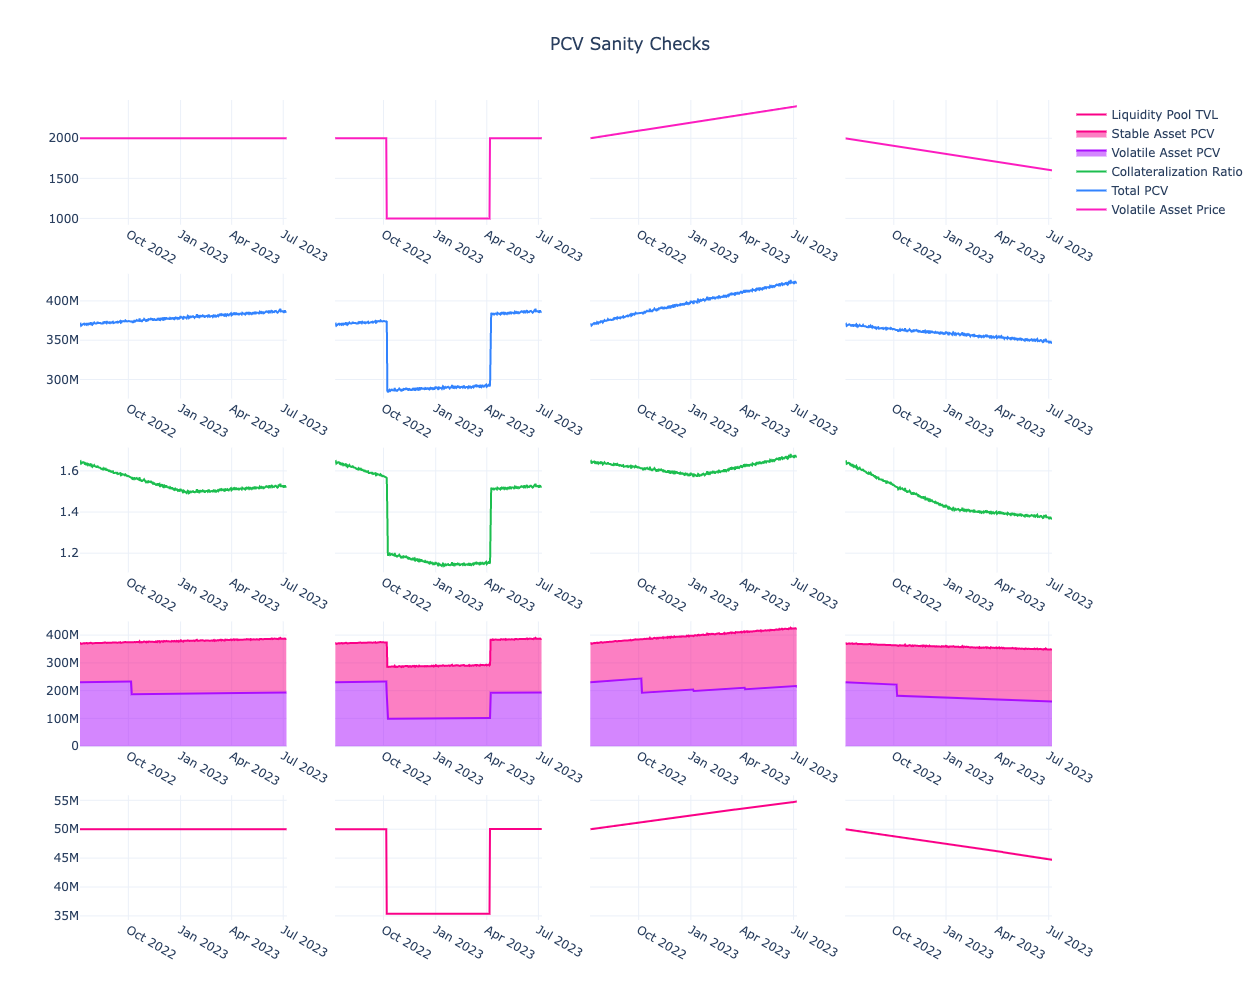

time: 839 ms (started: 2022-07-07 18:58:32 -04:00)


In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from experiments.notebooks.visualizations.plotly_theme import cadlabs_colorway_sequence
color_cycle = itertools.cycle(cadlabs_colorway_sequence)


fig = make_subplots(rows=5, cols=len(df.subset.unique()), shared_yaxes=True)

for subset in df.subset.unique():
    df_plot = df.query('subset == @subset')
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.volatile_asset_price,
            name="Volatile Asset Price",
            line=dict(color=cadlabs_colorway_sequence[0]),
            showlegend=(True if subset == 0 else False),
        ),
        row=1, col=subset+1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_pcv,
            name="Total PCV",
            line=dict(color=cadlabs_colorway_sequence[1]),
            showlegend=(True if subset == 0 else False),
        ),
        row=2, col=subset+1
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.collateralization_ratio,
            name="Collateralization Ratio",
            line=dict(color=cadlabs_colorway_sequence[2]),
            showlegend=(True if subset == 0 else False),
        ),
        row=3, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_volatile_asset_pcv,
            name="Volatile Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[3]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_stable_asset_pcv,
            name="Stable Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.liquidity_pool_tvl,
            name="Liquidity Pool TVL",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
        ),
        row=5, col=subset+1
    )


fig.update_layout(height=1000, title_text="PCV Sanity Checks")
fig.show()

# Analysis 2: Correlation Matrix

In [127]:
# Analysis-specific setup
simulation_2.model.params.update({})

time: 9.82 s (started: 2022-07-07 21:10:29 -04:00)


In [130]:
# Experiment execution
df_2, exceptions = run(simulation_2)

2022-07-07 21:11:30,574 - root - INFO - Running experiment
2022-07-07 21:11:30,831 - root - INFO - Setting up initial state
2022-07-07 21:11:31,139 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-07 21:11:35,809 - root - INFO - Experiment complete in 4.9789018630981445 seconds
2022-07-07 21:11:36,078 - root - INFO - Post-processing results
2022-07-07 21:11:40,360 - root - INFO - Post-processing complete in 4.550682306289673 seconds
time: 20.6 s (started: 2022-07-07 21:11:20 -04:00)


In [131]:
# Post-processing and visualizations

time: 11.7 s (started: 2022-07-07 21:11:41 -04:00)


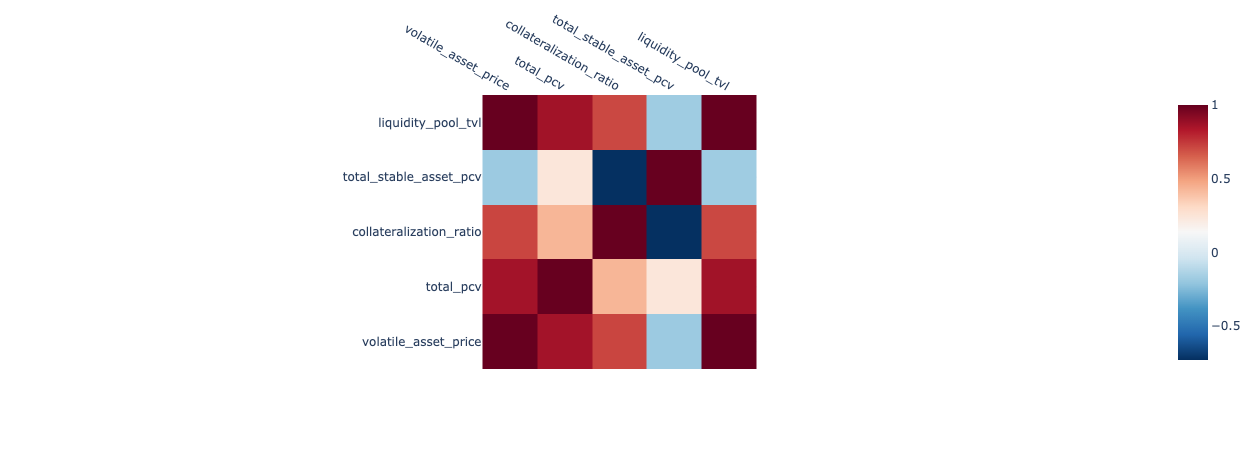

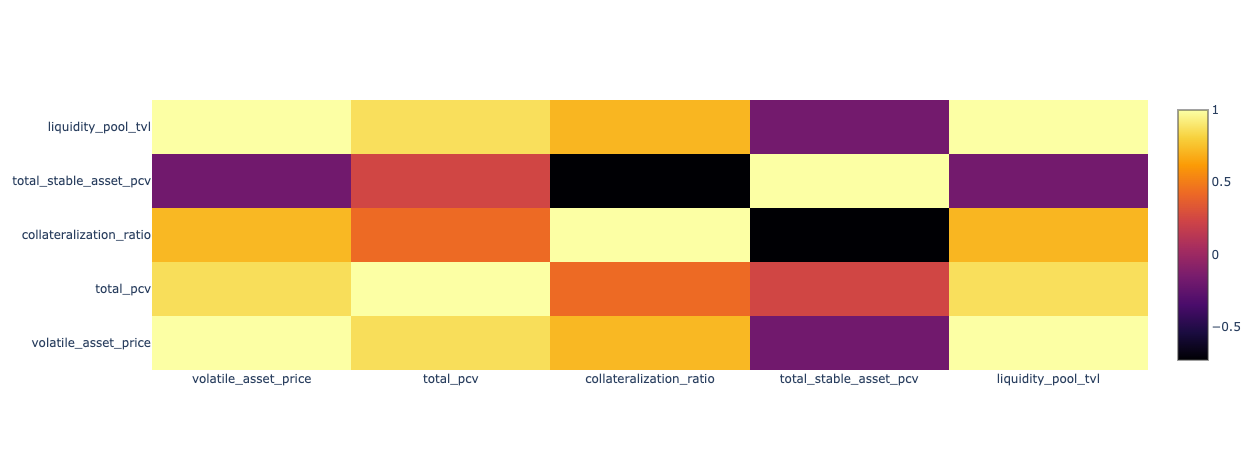

time: 12.1 s (started: 2022-07-07 21:14:55 -04:00)


In [137]:
import plotly.graph_objects as go


variables = [
    "volatile_asset_price",
    "total_pcv",
    "collateralization_ratio",
    "total_stable_asset_pcv",
    "liquidity_pool_tvl"
]

z = df_2[variables].corr().values.tolist()

fig = px.imshow(z, x=variables, y=variables, color_continuous_scale='RdBu_r', origin='lower')
fig.update_xaxes(side="top")
fig.show()

fig = go.Figure(data=go.Heatmap(
        z=z,
        x=variables,
        y=variables,
        colorscale='Inferno'
    )
)

fig.show()

# Analysis 3: PCV at Risk

In [139]:
from operator import lt, gt


simulation_3.runs = 10

parameter_overrides = {
    "target_rebalancing_condition": [gt, lt], # Simulate decrease and increase of stable PCV
    "target_stable_pcv_ratio": [0.2, 0.5], # Simulate decrease and increase of stable PCV
    "rebalancing_period": [int(365 / 4)],
}

simulation_3.model.params.update(parameter_overrides)

time: 6.99 s (started: 2022-07-07 21:19:08 -04:00)


In [140]:
# Experiment execution
df_3, exceptions = run(simulation_3)

2022-07-07 21:19:23,689 - root - INFO - Running experiment
2022-07-07 21:19:23,831 - root - INFO - Setting up initial state
2022-07-07 21:19:24,275 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-07 21:19:29,406 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-07 21:19:29,550 - root - INFO - Setting up initial state
2022-07-07 21:19:29,814 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-07 21:19:34,500 - root - INFO - Setting up initial state
2022-07-07 21:19:34,670 - root - INFO - Starting simulation 0 / run 1 / subset 0
2022-07-07 21:19:39,210 - root - INFO - Setting up initial state
2022-07-07 21:19:39,611 - root - INFO - Starting simulation 0 / run 1 / subset 1
2022-07-07 21:19:44,391 - root - INFO - Setting up initial state
2022-07-07 21:19:44,783 - root - INFO - Starting simulation 0 / run 2 / subset 0
2022-07-07 21:19:47,372 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-07 21:19:48,821 - root - WARNING - Cashing 

In [141]:
df = df_3

timestamp  total_fei_supply  \
timestamp                                                                 
2022-07-07 18:58:26.024676 2022-07-07 18:58:26.024676      4.500000e+08   
2022-07-08 18:58:26.024676 2022-07-08 18:58:26.024676      4.499191e+08   
2022-07-09 18:58:26.024676 2022-07-09 18:58:26.024676      4.499675e+08   
2022-07-10 18:58:26.024676 2022-07-10 18:58:26.024676      4.499175e+08   
2022-07-11 18:58:26.024676 2022-07-11 18:58:26.024676      4.500538e+08   
...                                               ...               ...   
2023-07-02 18:58:26.024676 2023-07-02 18:58:26.024676      4.479105e+08   
2023-07-03 18:58:26.024676 2023-07-03 18:58:26.024676      4.477168e+08   
2023-07-04 18:58:26.024676 2023-07-04 18:58:26.024676      4.476411e+08   
2023-07-05 18:58:26.024676 2023-07-05 18:58:26.024676      4.475162e+08   
2023-07-06 18:58:26.024676 2023-07-06 18:58:26.024676      4.475146e+08   

                            total_protocol_owned_fei  \
timestamp                                              
2022-07-07 18:58:26.024676              2.250000e+08   
2022-07-08 18:58:26.024676              2.247691e+08   
2022-07-09 18:58:26.024676              2.246675e+08   
2022-07-10 18:58:26.024676              2.244675e+08   
2022-07-11 18:58:26.024676              2.244538e+08   
...                                              ...   
2023-07-02 18:58:26.024676              1.944105e+08   
2023-07-03 18:58:26.024676              1.942168e+08   
2023-07-04 18:58:26.024676              1.941411e+08   
2023-07-05 18:58:26.024676              1.940162e+08   
2023-07-06 18:58:26.024676              1.940146e+08   

                            total_user_circulating_fei  \
timestamp                                                
2022-07-07 18:58:26.024676                 225000000.0   
2022-07-08 18:58:26.024676                 225150000.0   
2022-07-09 18:58:26.024676                 225300000.0   
2022-07-10 18:58:26.024676                 225450000.0   
2022-07-11 18:58:26.024676                 225600000.0   
...                                                ...   
2023-07-02 18:58:26.024676                 253500000.0   
2023-07-03 18:58:26.024676                 253500000.0   
2023-07-04 18:58:26.024676                 253500000.0   
2023-07-05 18:58:26.024676                 253500000.0   
2023-07-06 18:58:26.024676                 253500000.0   

                            idle_user_circulating_fei  fei_minted_redeemed  \
timestamp                                                                    
2022-07-07 18:58:26.024676                  225000000        -80915.167672   
2022-07-08 18:58:26.024676                  225000000         48406.511729   
2022-07-09 18:58:26.024676                  225000000        -49973.740747   
2022-07-10 18:58:26.024676                  225000000        136273.662341   
2022-07-11 18:58:26.024676                  225000000       -335837.919999   
...                                               ...                  ...   
2023-07-02 18:58:26.024676                  225000000       -193674.104858   
2023-07-03 18:58:26.024676                  225000000        -75687.135543   
2023-07-04 18:58:26.024676                  225000000       -124859.241520   
2023-07-05 18:58:26.024676                  225000000         -1605.215082   
2023-07-06 18:58:26.024676                  225000000       -146900.046528   

                            cumulative_psm_redemptions  fei_price  \
timestamp                                                           
2022-07-07 18:58:26.024676                         0.0        1.0   
2022-07-08 18:58:26.024676                         0.0        1.0   
2022-07-09 18:58:26.024676                         0.0        1.0   
2022-07-10 18:58:26.024676                         0.0        1.0   
2022-07-11 18:58:26.024676                         0.0        1.0   
...                                                ...        ...   
2023-07-02 18:58:

time: 25.7 s (started: 2022-07-07 21:21:59 -04:00)


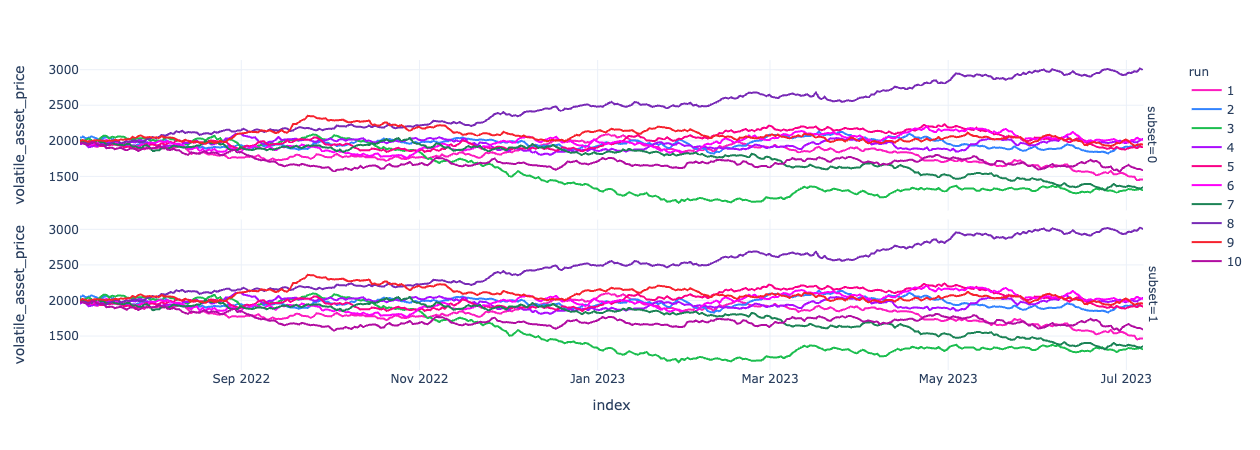

time: 11 s (started: 2022-07-07 21:22:25 -04:00)


In [142]:
df.plot(y="volatile_asset_price", color="run", facet_row="subset")

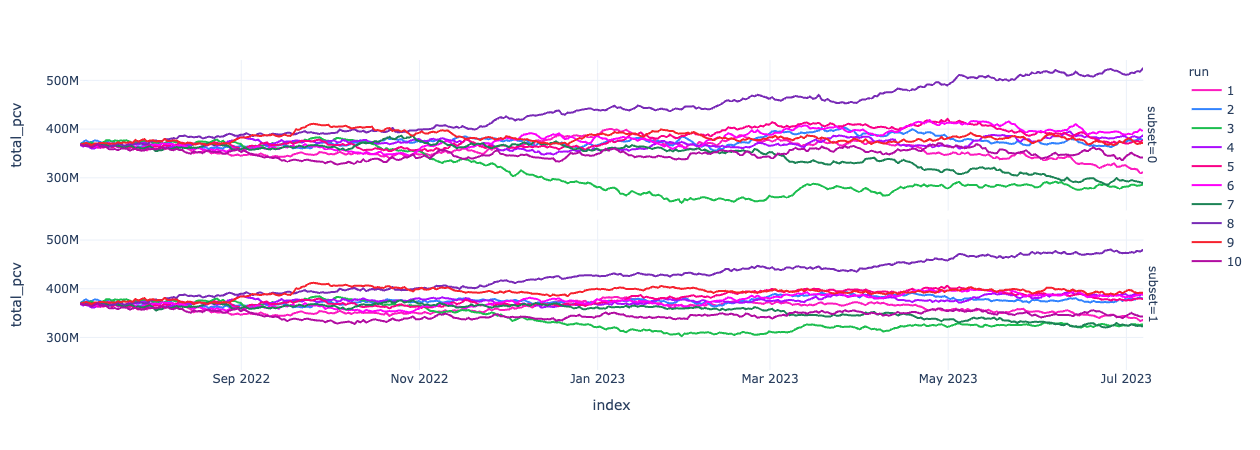

time: 16.7 s (started: 2022-07-07 21:22:37 -04:00)


In [143]:
df.plot(y="total_pcv", color="run", facet_row="subset")

## Vectorized PCV at Risk

In [144]:
def calculate_VaR_run(df, n_run, alpha, n_timesteps, t_start, t_end):
    pcv_ret = df.query('run==@n_run and (timestep > @t_start and timestep <= @t_end)')['total_pcv'].pct_change()
    pcv_final_val = df.query('run==@n_run')['total_pcv'].iloc[-1]
    q = pcv_ret.quantile(1-alpha)
    # see https://www0.gsb.columbia.edu/faculty/pglasserman/B6014/var-d.pdf
    # for n-day var simplifying assumption which allows for generalization
    VaR_n = abs(pcv_final_val * q)*np.sqrt(n_timesteps)
    
    return VaR_n, q

time: 8.83 s (started: 2022-07-07 21:22:54 -04:00)


In [145]:
def calculate_VaR_subset(df, n_subset, alpha, n_timesteps, t_start, t_end):
    VAR = []
    
    df_ = df.query("subset==@n_subset")
    for run in df_['run'].value_counts().index:
        var, q = calculate_VaR_run(df_, run, alpha, n_timesteps, t_start, t_end)
        
        VAR.append((n_subset, var, q))
    
    return pd.DataFrame(VAR, columns=[x+'_'+str(n_timesteps) for x in ['subset', 'VaR', 'q']])

time: 16.7 s (started: 2022-07-07 21:23:04 -04:00)


In [146]:
def calculate_VaR(df, alpha, n_timesteps, t_start, t_end):
    L = []
    
    for subset in df['subset'].value_counts().index:
        VaR_subset = calculate_VaR_subset(df, subset, alpha, n_timesteps, t_start, t_end)
        L.append(VaR_subset)
        
    return pd.concat(L, axis=0).reset_index(drop=True)

time: 18.2 s (started: 2022-07-07 21:23:22 -04:00)


In [147]:
def calculate_VaR_n(df, alpha, timestep_range, t_start, t_end):
    U, L = [], []
    
    for t in range(timestep_range):
        L.append(calculate_VaR(df, 0.95, t+1, t_start, t_end))
        U.append(t+1)
        
    return dict(zip(U, L))

time: 16.2 s (started: 2022-07-07 21:23:41 -04:00)


In [148]:
def calculate_VaR_summary_stats(df, n_timesteps):
    L = []
    colnames = []
    for subset in df['subset'+'_'+str(n_timesteps)].value_counts().index:
        L.append(df.query('subset'+'_'+str(n_timesteps)+'==@subset').describe())
        colnames += [colname+'_'+str(subset) for colname in df.columns]
    
    VAR_info = pd.concat(L, axis=1)
    VAR_info.columns = colnames
    VAR_info = VAR_info.drop(index=['count'])
    return VAR_info
        

time: 14.7 s (started: 2022-07-07 21:23:58 -04:00)


In [149]:
# calculate 1-day vectorized VaR for all simulation outputs
# set window bounds, whole simulation for simplicity
t_start = 0
t_end = 365
alpha = 0.95
max_day_VaR = 10
VAR_df = calculate_VaR_n(df, alpha, max_day_VaR, t_start, t_end)

# NOTE: create rolling window by further vectorizing VaR calculation by iterating over start and end time

time: 39.6 s (started: 2022-07-07 21:24:14 -04:00)


In [150]:
VAR_1_stats = calculate_VaR_summary_stats(VAR_df[1], 1)

time: 25.8 s (started: 2022-07-07 21:24:54 -04:00)


In [151]:
VAR_10_stats = calculate_VaR_summary_stats(VAR_df[10], 10)

time: 12.9 s (started: 2022-07-07 21:25:21 -04:00)


## 1-day PCV at Risk

In [153]:
VAR_1_stats

subset_1_0       VaR_1_0     q_1_0  subset_1_1       VaR_1_1     q_1_1
mean         0.0  4.558287e+06 -0.012684         1.0  3.657313e+06 -0.009880
std          0.0  3.466965e+05  0.002007         0.0  2.256864e+05  0.001058
min          0.0  4.147022e+06 -0.015664         1.0  3.383477e+06 -0.011449
25%          0.0  4.332894e+06 -0.014528         1.0  3.531391e+06 -0.010579
50%          0.0  4.426360e+06 -0.011894         1.0  3.570583e+06 -0.009866
75%          0.0  4.705887e+06 -0.011460         1.0  3.816863e+06 -0.009123
max          0.0  5.223563e+06 -0.009558         1.0  4.073601e+06 -0.008111

time: 4.97 s (started: 2022-07-07 21:25:36 -04:00)


In [214]:
# print('Over the simulation, for parameters in the sweep corresponding to subset 0,',
#       np.round(VAR_1_stats['VaR_1_0'].loc['mean'], 2), 'USD is the mean 1-Day PCVaR at 95% over the 20 runs performed, with associated',
#       np.round(VAR_1_stats['q_1_0'].loc['mean'], 4), '% average 5% quantile percentile loss')

time: 42 ms (started: 2022-07-07 22:11:21 -04:00)


In [215]:
# print('Over the simulation, for parameters in the sweep corresponding to subset 1,',
#       np.round(VAR_1_stats['VaR_1_1'].loc['mean'], 2), 'USD is the mean 1-Day PCVaR at 95% over the 20 runs performed, with associated',
#       np.round(VAR_1_stats['q_1_1'].loc['mean'], 4), '% average 5% quantile percentile loss')

time: 46.8 ms (started: 2022-07-07 22:11:21 -04:00)


In [213]:
print(f"1-day PCV at Risk at 95th quantile for subset 0: \n {np.round(VAR_1_stats['VaR_1_0'].loc['mean'], 2):,} USD")

1-day PCV at Risk at 95th quantile for subset 0: 
 4,558,287.34 USD
time: 42.6 ms (started: 2022-07-07 22:11:18 -04:00)


In [212]:
print(f"1-day PCV at Risk at 95th quantile for subset 1: \n {np.round(VAR_1_stats['VaR_1_1'].loc['mean'], 2):,} USD")

1-day PCV at Risk at 95th quantile for subset 1: 
 3,657,313.36 USD
time: 47.8 ms (started: 2022-07-07 22:11:17 -04:00)


## 10-day PCV at Risk

In [158]:
VAR_10_stats

subset_10_0      VaR_10_0    q_10_0  subset_10_1      VaR_10_1    q_10_1
mean          0.0  1.441457e+07 -0.012684          1.0  1.156544e+07 -0.009880
std           0.0  1.096351e+06  0.002007          0.0  7.136830e+05  0.001058
min           0.0  1.311403e+07 -0.015664          1.0  1.069950e+07 -0.011449
25%           0.0  1.370182e+07 -0.014528          1.0  1.116724e+07 -0.010579
50%           0.0  1.399738e+07 -0.011894          1.0  1.129117e+07 -0.009866
75%           0.0  1.488132e+07 -0.011460          1.0  1.206998e+07 -0.009123
max           0.0  1.651836e+07 -0.009558          1.0  1.288186e+07 -0.008111

time: 5.49 s (started: 2022-07-07 21:26:02 -04:00)


In [208]:
# print('Over the simulation, for parameters in the sweep corresponding to subset 0,',
#       np.round(VAR_10_stats['VaR_10_0'].loc['mean'], 2), 'USD is the mean 10-Day PCVaR at 95% over the 20 runs performed, with associated',
#       np.round(VAR_10_stats['q_10_0'].loc['mean'], 4), '% average 5% quantile percentile loss')

time: 48 ms (started: 2022-07-07 22:10:12 -04:00)


In [209]:
# print('Over the simulation, for parameters in the sweep corresponding to subset 1,',
#       np.round(VAR_10_stats['VaR_10_1'].loc['mean'], 2), 'USD is the mean 10-Day PCVaR at 95% over the 20 runs performed, with associated',
#       np.round(VAR_10_stats['q_10_1'].loc['mean'], 4), '% average 5% quantile percentile loss')

time: 48.9 ms (started: 2022-07-07 22:10:12 -04:00)


In [206]:
print(f"10-day PCV at Risk at 95th quantile for subset 0: \n {np.round(VAR_10_stats['VaR_10_0'].loc['mean'], 2):,} USD")

10-day PCV at Risk at 95th quantile for subset 0: 
 14,414,570.21 USD
time: 41.4 ms (started: 2022-07-07 22:06:26 -04:00)


In [207]:
print(f"10-day PCV at Risk at 95th quantile for subset 1: \n {np.round(VAR_10_stats['VaR_10_1'].loc['mean'], 2):,} USD")

10-day PCV at Risk at 95th quantile for subset 1: 
 11,565,440.32 USD
time: 43 ms (started: 2022-07-07 22:06:26 -04:00)


## Summary Statistics

In [183]:
_df = df.groupby(['subset','timestep']).mean().query('subset == 0')
stats_df = _df.describe()
stats_df.loc['skew'] = _df.skew()
stats_df.loc['kurtosis'] = _df.kurtosis()
# TODO: max drawdown & other relevant summary stats here

stats_df

total_fei_supply  total_protocol_owned_fei  \
count         3.650000e+02              3.650000e+02   
mean          4.495885e+08              2.035454e+08   
std           2.145404e+05              9.454221e+06   
min           4.489638e+08              1.954638e+08   
25%           4.494778e+08              1.960305e+08   
50%           4.496264e+08              1.973971e+08   
75%           4.497180e+08              2.110778e+08   
max           4.500026e+08              2.250000e+08   
skew         -8.288502e-01              8.669813e-01   
kurtosis      6.963336e-01             -7.339239e-01   

          total_user_circulating_fei  idle_user_circulating_fei  \
count                   3.650000e+02                      365.0   
mean                    2.460432e+08                225000000.0   
std                     9.310525e+06                        0.0   
min                     2.250000e+08                225000000.0   
25%                     2.386500e+08                225000000.0   
50%                     2.523000e+08                225000000.0   
75%                     2.535000e+08                225000000.0   
max                     2.535000e+08                225000000.0   
skew                   -8.692639e-01                        0.0   
kurtosis               -7.314980e-01                        0.0   

          fei_minted_redeemed  cumulative_psm_redemptions  fei_price  \
count              365.000000                       365.0      365.0   
mean             -2786.248460                         0.0        1.0   
std              38339.428507                         0.0        0.0   
min            -125295.946028                         0.0        1.0   
25%             -30348.447020                         0.0        1.0   
50%              -2791.581346                         0.0        1.0   
75%              23437.314883                         0.0        1.0   
max              91386.983330                         0.0        1.0   
skew                -0.029720                         0.0        0.0   
kurtosis            -0.282137                         0.0        0.0   

          volatile_asset_price  stable_asset_price  liquidity_pool_invariant  \
count               365.000000          365.000000              3.650000e+02   
mean               1941.159748            0.999919              3.132048e+11   
std                  29.995302            0.001506              4.145436e+08   
min                1854.483962            0.995011              3.125054e+11   
25%                1925.564396            0.998975              3.128442e+11   
50%                1947.865400            0.999923              3.131951e+11   
75%                1960.358194            1.000828              3.135628e+11   
max                2000.488432            1.004883              3.139343e+11   
skew                 -0.828259            0.105769              4.722865e-02   
kurtosis              0.644610            0.267246             -1.213651e+00   

          ...  volatile_deposit_yield_bearing_balance  \
count     ...                                   365.0   
mean      ...                                 51250.0   
std       ...                                     0.0   
min       ...                                 51250.0   
25%       ...                                 51250.0   
50%       ...                                 51250.0   
75%       ...                                 51250.0   
max       ...                                 51250.0   
skew      ...                                     0.0   
kurtosis  ...                                     0.0   

          volatile_deposit_yield_bearing_asset_value  \
count                                          365.0   
mean                                     102500000.0   
std                                              0.0   
min                                      102500000.0   
25%                                      102500000.0   
50%              

time: 269 ms (started: 2022-07-07 21:56:53 -04:00)


# Analysis 4: Capital Allocation Metrics

In [244]:
fei_capital_allocation_variables = [
    'fei_deposit_idle_balance',
    'fei_deposit_liquidity_pool_balance',
    'fei_deposit_money_market_balance'
]
fei_capital_allocation_variables.sort()

time: 41.2 ms (started: 2022-07-07 22:30:24 -04:00)


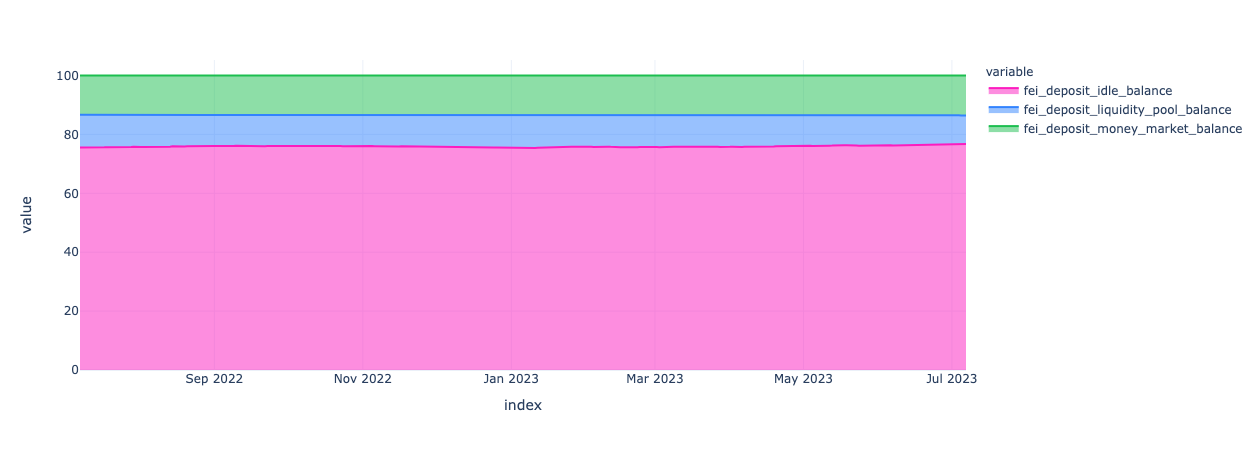

time: 160 ms (started: 2022-07-07 22:34:39 -04:00)


In [258]:
import plotly.express as px

px.area(df_2.sort_index(), y=fei_capital_allocation_variables, groupnorm='percent')

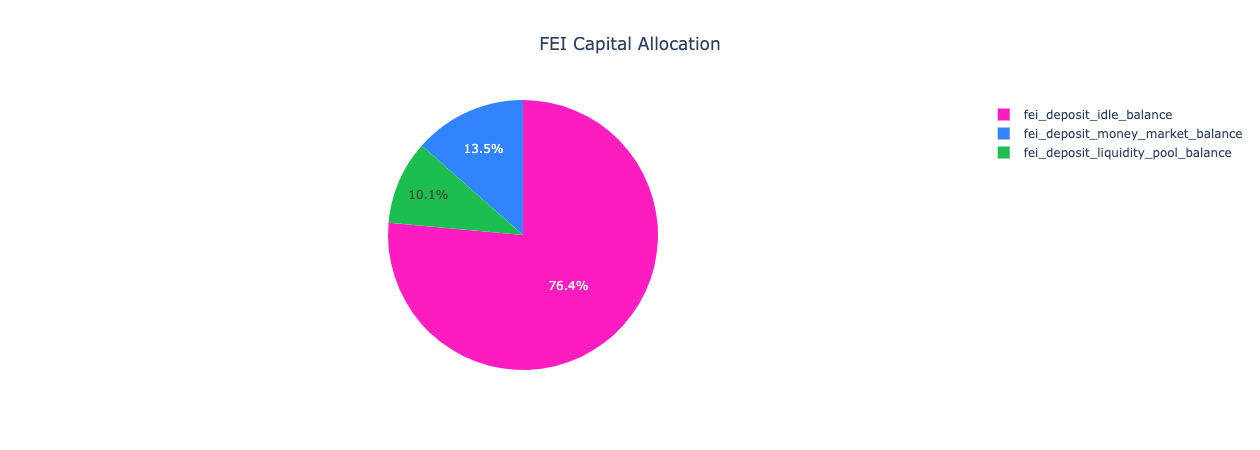

time: 75.6 ms (started: 2022-07-07 22:32:03 -04:00)


In [256]:
df_allocations = df[fei_capital_allocation_variables].iloc[-1]

px.pie(df_allocations.sort_index(), title='FEI Capital Allocation', values=df_allocations.values, names=df_allocations.index)

# Assorted Metrics

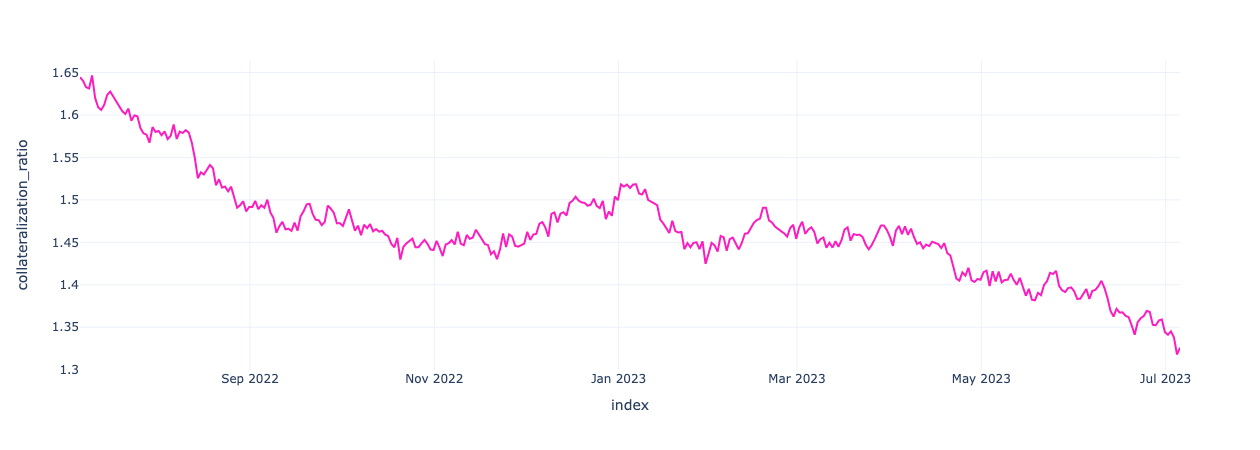

time: 92.9 ms (started: 2022-07-06 18:11:06 -04:00)


In [42]:
df_2.plot(y="collateralization_ratio")

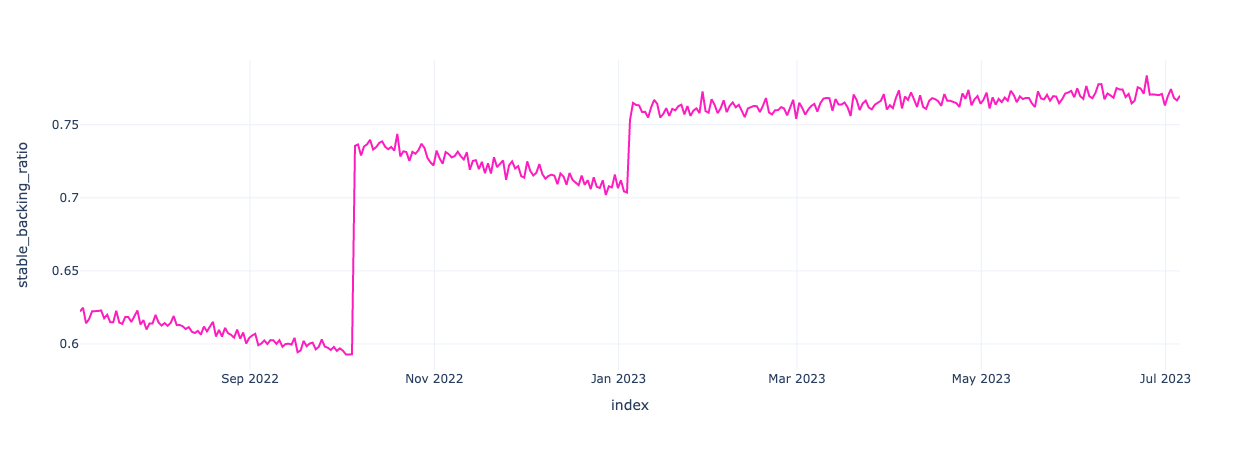

time: 103 ms (started: 2022-07-06 18:04:41 -04:00)


In [36]:
df_2.plot(y="stable_backing_ratio")

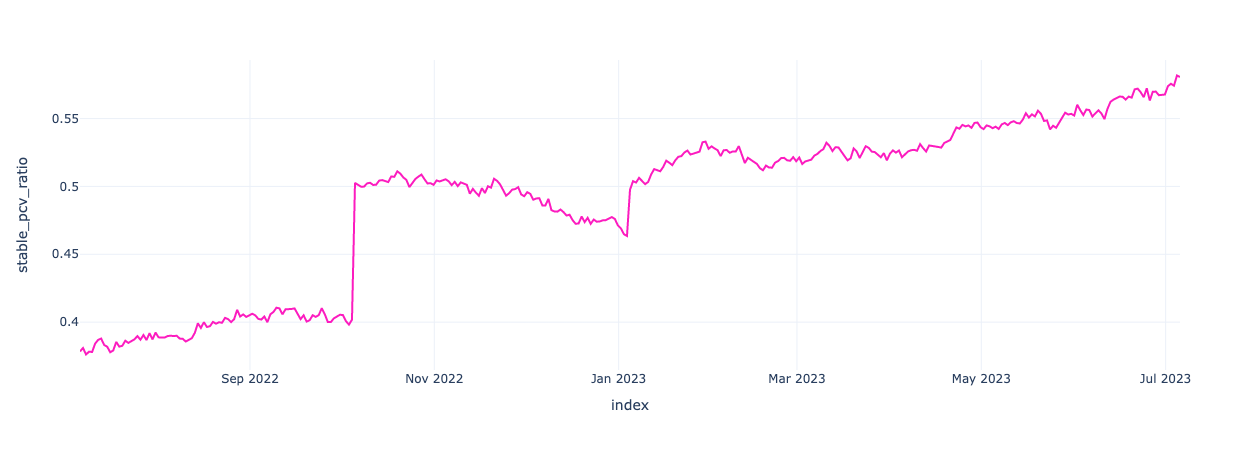

time: 94.5 ms (started: 2022-07-06 18:12:37 -04:00)


In [43]:
df_2.plot(y="stable_pcv_ratio")

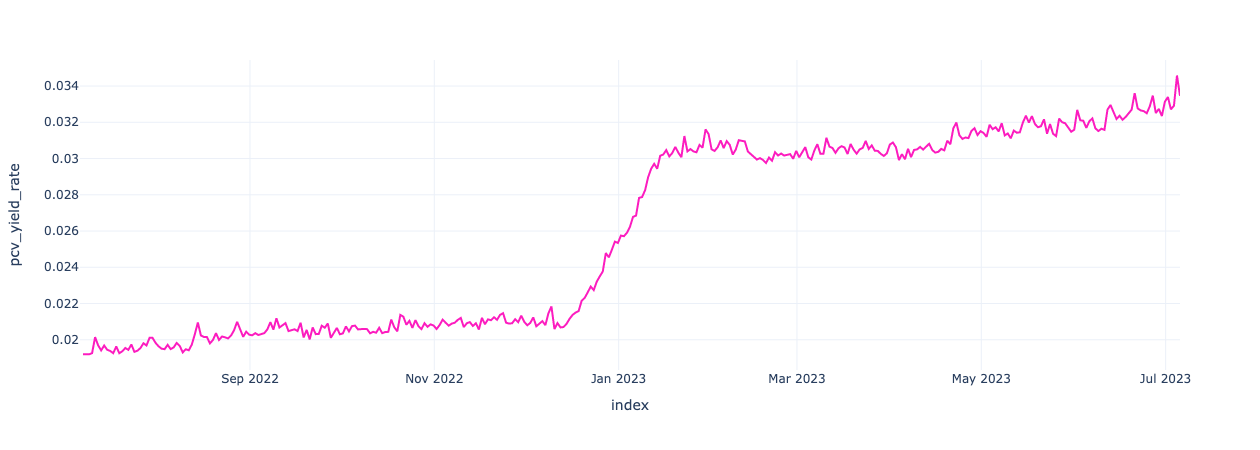

time: 102 ms (started: 2022-07-06 18:04:42 -04:00)


In [37]:
df_2.plot(y="pcv_yield_rate")

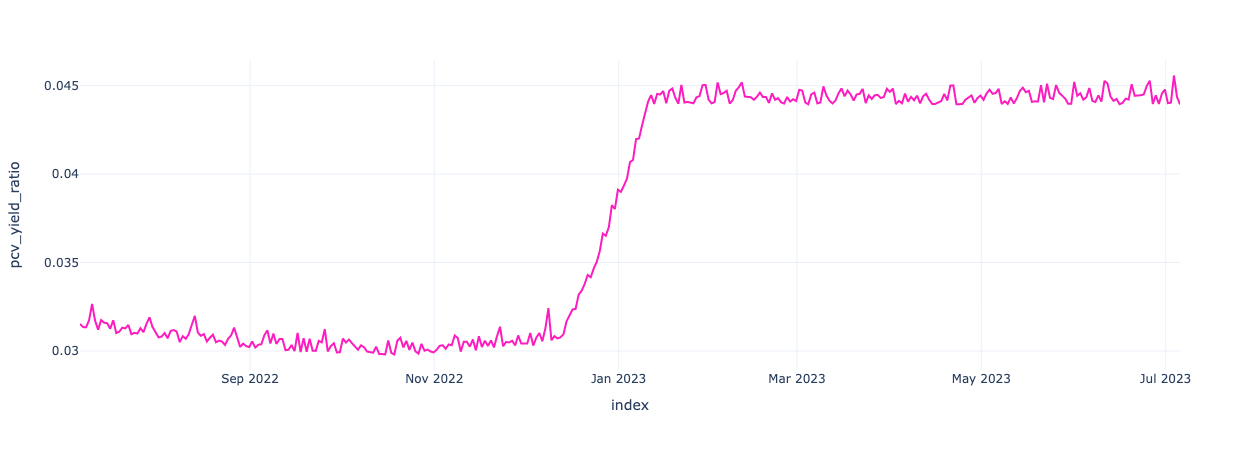

time: 99 ms (started: 2022-07-06 18:06:54 -04:00)


In [41]:
df_2["pcv_yield_ratio"] = df_2["pcv_yield"] / df_2["total_user_circulating_fei"] * 365 / df_2["dt"]

df_2.plot(y="pcv_yield_ratio")